In [ ]:
pip install seaborn

In [26]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [28]:
# Función para extraer características (MFCCs) de los clips de audio
def extract_features(file_path, res_type='kaiser_fast'):
    audio, sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled


In [29]:
metadata = pd.read_csv('D:/Workspace/tesis/audioMetadata/archive/UrbanSound8K2.csv')
audio_path = 'D:/Workspace/tesis/audioMetadata/archive'
print(metadata.head())


      slice_file_name      fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032.0    0.0   0.317551       1.0     5        3   
1  100263-2-0-117.wav  100263.0   58.5  62.500000       1.0     5        2   
2  100263-2-0-121.wav  100263.0   60.5  64.500000       1.0     5        2   
3  100263-2-0-126.wav  100263.0   63.0  67.000000       1.0     5        2   
4  100263-2-0-137.wav  100263.0   68.5  72.500000       1.0     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [30]:
# Listas para almacenar las características y las etiquetas
features = []
labels = []

num_gunshot_wav = 0
num_no_gunshot_wav = 0
limit = 6000

# Recorrer los archivos de audio y extraer las características
for index, row in metadata.iterrows():
    clear_output(wait=True)
    if num_gunshot_wav == limit & num_no_gunshot_wav == limit:
        break
    else:
        Id = row['classID']
        if Id != 6:
            if num_no_gunshot_wav == limit:
                print("skip")
                continue
            else:
                num_no_gunshot_wav = num_no_gunshot_wav + 1
        else:
            if num_gunshot_wav == limit:
                print("skip")
                continue
            else:
                num_gunshot_wav = num_gunshot_wav + 1
            
        file_name = os.path.join(audio_path, f"fold{row['fold']}", row['slice_file_name'])
        print(f"fold{row['fold']}/ {row['slice_file_name']}  -->  join")
        class_id = row['classID']
        # Etiquetar como '1' si classID es 6, de lo contrario como '0'
        class_label = 1.0 if class_id == 6 else 0.0
        data = extract_features(file_name)
        features.append(data)
        labels.append(class_label) 
        time.sleep(0.01)

fold11/ 15d53f4b-0e9d-476e-b321-6ca604f89412_mean_v0.wav  -->  join


In [32]:
print(f"num G:{num_gunshot_wav}, num no G:{num_no_gunshot_wav}")
# Convertir las listas a arrays de numpy 
X = np.array(features)
y = np.array(labels)

num G:2522, num no G:6000


In [33]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo CNN
model = Sequential()
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))  # Cambiado a 1 salida para clasificación binaria
model.add(Activation('sigmoid'))  # Usar 'sigmoid' para clasificación binaria

# Compilar el modelo
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

c:\Users\huday\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1)

# Guardar el modelo entrenado
model.save('gunshot_detection_model_NEW.h5')

# Evaluar el modelo en el conjunto de prueba
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {score[1]}')

# Predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,545 (299.00 KB)

 Trainable params: 76,545 (299.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6657 - loss: 7.7671 - val_accuracy: 0.8596 - val_loss: 0.3630
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7709 - loss: 1.1350 - val_accuracy: 0.8725 - val_loss: 0.3798
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8096 - loss: 0.5041 - val_accuracy: 0.8792 - val_loss: 0.3341
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8394 - loss: 0.4072 - val_accuracy: 0.9069 - val_loss: 0.2750
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8657 - loss: 0.3362 - val_accuracy: 0.9050 - val_loss: 0.2640
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8700 - loss: 0.3242 - val_accuracy: 0.9136 - val_loss: 0.2353
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8877 - loss: 0.2843 - val_accuracy: 0.9222 - val_loss: 0.2092
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8882 - loss: 0.2661 - val_accuracy: 0.

Accuracy: 0.9761438965797424
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


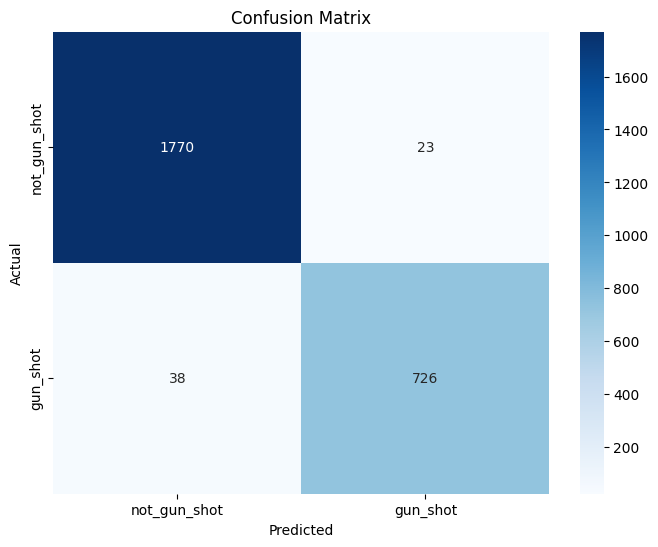

              precision    recall  f1-score   support

not_gun_shot       0.98      0.99      0.98      1793
    gun_shot       0.97      0.95      0.96       764

    accuracy                           0.98      2557
   macro avg       0.97      0.97      0.97      2557
weighted avg       0.98      0.98      0.98      2557



In [35]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['not_gun_shot', 'gun_shot'], columns=['not_gun_shot', 'gun_shot'])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['not_gun_shot', 'gun_shot'])
print(report)